In [3]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [4]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = '../input/cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal',
           IMG_ROOT+'2_cataract',
           IMG_ROOT+'2_glaucoma',
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx')

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [6]:
cat_df = pd.DataFrame(0,
                  columns=['paths',
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3

# only sample normal and cataract
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
201,../input/cataractdataset/dataset/2_cataract/ca...,1
202,../input/cataractdataset/dataset/2_cataract/ca...,1
203,../input/cataractdataset/dataset/2_cataract/ca...,1
204,../input/cataractdataset/dataset/2_cataract/ca...,1
205,../input/cataractdataset/dataset/2_cataract/ca...,1
...,...,...
596,../input/cataractdataset/dataset/1_normal/NL_1...,0
597,../input/cataractdataset/dataset/1_normal/NL_0...,0
598,../input/cataractdataset/dataset/1_normal/NL_2...,0
599,../input/cataractdataset/dataset/1_normal/NL_0...,0


In [7]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


In [8]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [9]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [10]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [11]:
le_df.head()

,cataract,paths
0,1,../input/ocular-disease-recognition-odir5k/ODI...
1,0,../input/ocular-disease-recognition-odir5k/ODI...
2,0,../input/ocular-disease-recognition-odir5k/ODI...
3,0,../input/ocular-disease-recognition-odir5k/ODI...
4,0,../input/ocular-disease-recognition-odir5k/ODI...


In [12]:
re_df.head()

,cataract,paths
0,0,../input/ocular-disease-recognition-odir5k/ODI...
1,0,../input/ocular-disease-recognition-odir5k/ODI...
2,0,../input/ocular-disease-recognition-odir5k/ODI...
3,0,../input/ocular-disease-recognition-odir5k/ODI...
4,0,../input/ocular-disease-recognition-odir5k/ODI...


In [13]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


There is a large bias in the dataset. So make it even.

In [14]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']),
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [15]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,../input/ocular-disease-recognition-odir5k/ODI...
81,1,../input/ocular-disease-recognition-odir5k/ODI...
103,1,../input/ocular-disease-recognition-odir5k/ODI...
119,1,../input/ocular-disease-recognition-odir5k/ODI...
253,1,../input/ocular-disease-recognition-odir5k/ODI...


In [16]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,../input/cataractdataset/dataset/2_cataract/ca...,1
1,../input/cataractdataset/dataset/2_cataract/ca...,1
2,../input/cataractdataset/dataset/2_cataract/ca...,1
3,../input/cataractdataset/dataset/2_cataract/ca...,1
4,../input/cataractdataset/dataset/2_cataract/ca...,1
...,...,...
1021,../input/ocular-disease-recognition-odir5k/ODI...,0
1022,../input/ocular-disease-recognition-odir5k/ODI...,0
1023,../input/ocular-disease-recognition-odir5k/ODI...,0
1024,../input/ocular-disease-recognition-odir5k/ODI...,0


In [17]:
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [18]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [00:13<00:00, 15.30it/s]


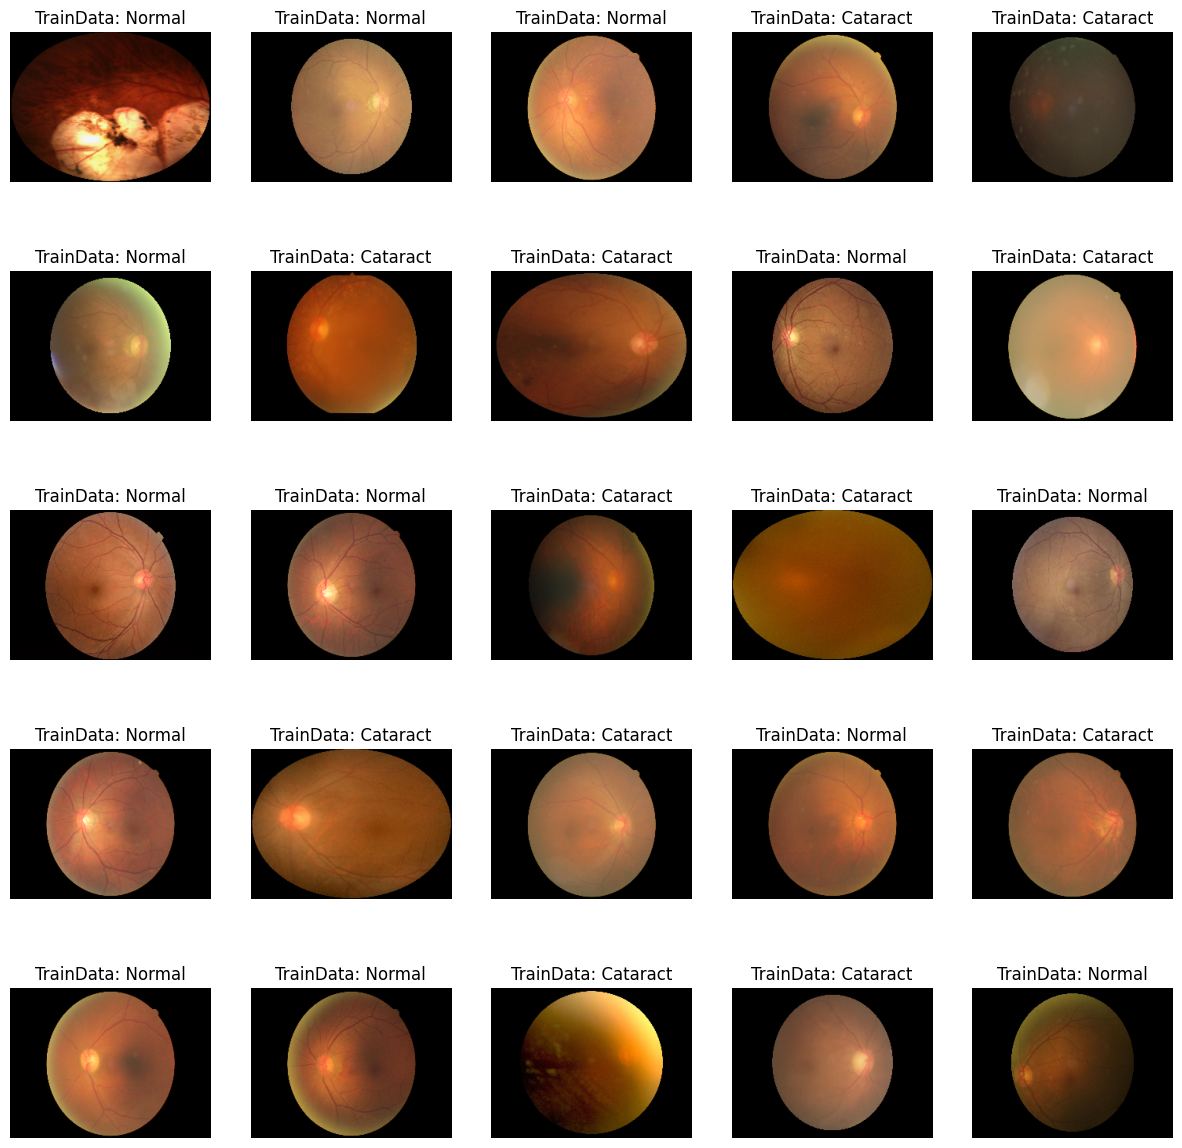

In [19]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

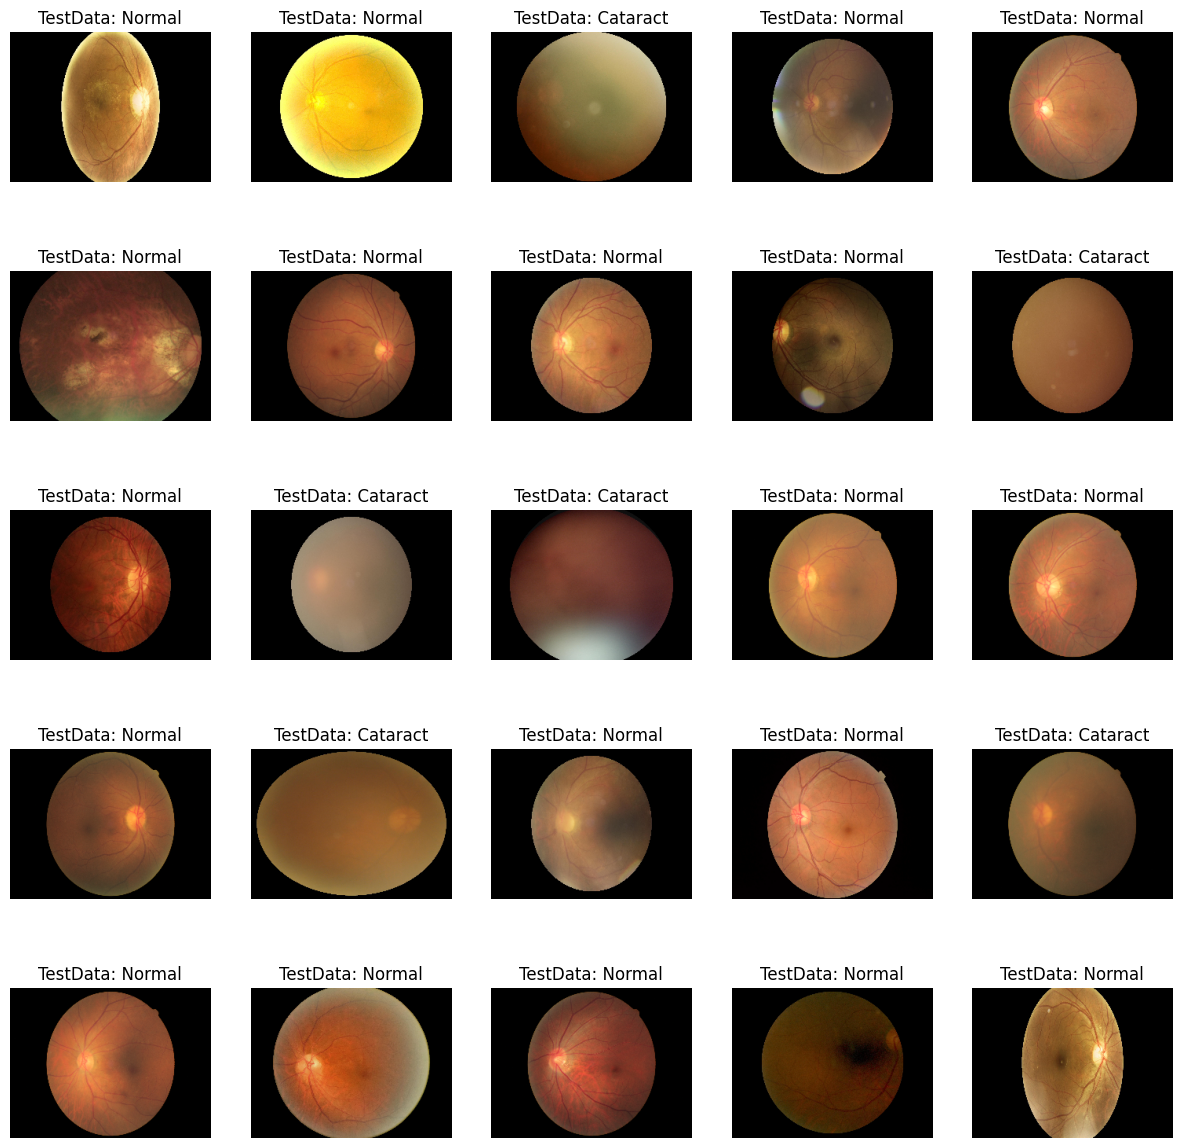

In [20]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [21]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)

get_custom_objects().update({'mish': Activation(mish)})

In [22]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same',
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 192, 256, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 85, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 85, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 85, 16)        2

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [23]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
21/21 [==============================] - 18s 442ms/step - loss: 1.5292 - accuracy: 0.6643 - val_loss: 0.6611 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 8s 355ms/step - loss: 0.8958 - accuracy: 0.6901 - val_loss: 0.6608 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 9s 410ms/step - loss: 0.9659 - accuracy: 0.7418 - val_loss: 0.6747 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 9s 397ms/step - loss: 1.0589 - accuracy: 0.6944 - val_loss: 0.6424 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 9s 394ms/step - loss: 0.8540 - accuracy: 0.7116 - val_loss: 0.5957 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 8s 341ms/step - loss: 0.7707 - accuracy: 0.7475 - val_loss: 0.6427 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 8s 388ms/s

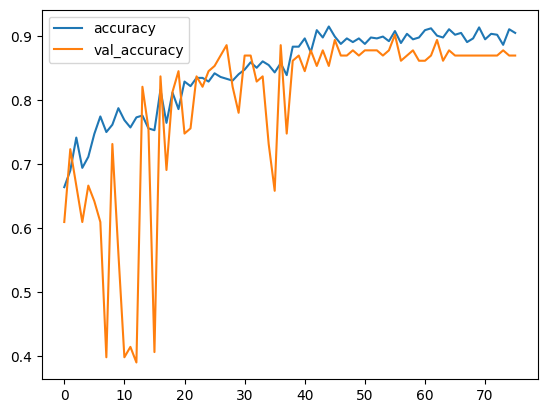

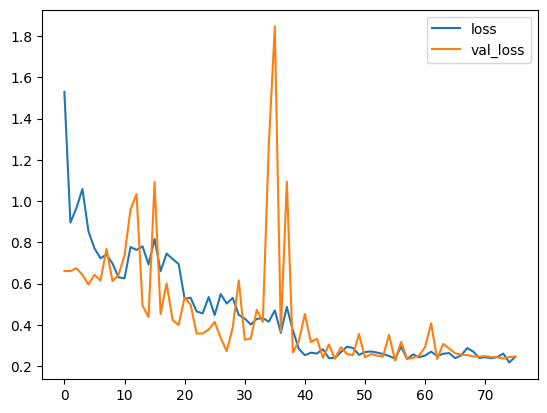

In [24]:
history = model.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [25]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 0s 67ms/step - loss: 0.3913 - accuracy: 0.8883


[0.39126038551330566, 0.8883495330810547]

In [26]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 efficientnet-b0 (Functiona  (None, 6, 8, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4052126 (15.46 MB)
Trainable params: 4010110 (15.30 MB)
Non-trainable params: 42016 (164.12 KB)
__________________

In [27]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
21/21 [==============================] - 52s 638ms/step - loss: 0.6701 - accuracy: 0.5968 - val_loss: 0.6525 - val_accuracy: 0.6260 - lr: 3.0000e-06
Epoch 2/100
21/21 [==============================] - 10s 474ms/step - loss: 0.6334 - accuracy: 0.6471 - val_loss: 0.6933 - val_accuracy: 0.5366 - lr: 3.0000e-06
Epoch 3/100
21/21 [==============================] - 10s 472ms/step - loss: 0.5980 - accuracy: 0.7030 - val_loss: 0.7211 - val_accuracy: 0.4634 - lr: 3.0000e-06
Epoch 4/100
21/21 [==============================] - 10s 464ms/step - loss: 0.5716 - accuracy: 0.7461 - val_loss: 0.7255 - val_accuracy: 0.4878 - lr: 3.0000e-06
Epoch 5/100
21/21 [==============================] - 10s 463ms/step - loss: 0.5532 - accuracy: 0.7676 - val_loss: 0.7142 - val_accuracy: 0.4715 - lr: 3.0000e-06
Epoch 6/100
21/21 [==============================] - 9s 424ms/step - loss: 0.5139 - accuracy: 0.8034 - val_loss: 0.7011 - val_accuracy: 0.5203 - lr: 3.0000e-06
Epoch 7/100
21/21 [================

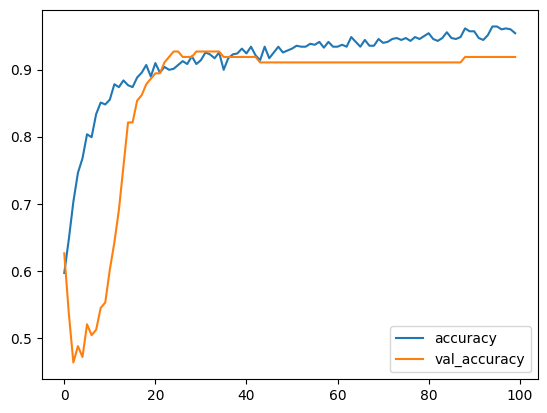

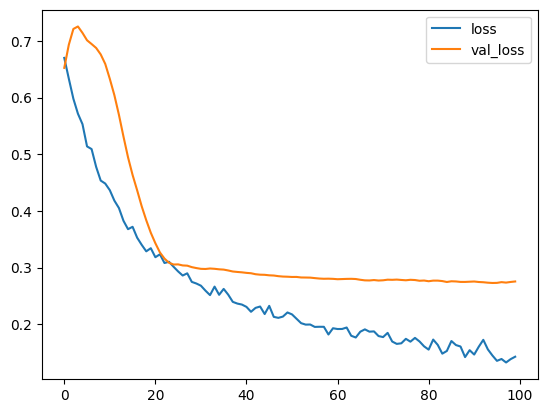

In [28]:
history = model.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [29]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 2s 235ms/step - loss: 0.2334 - accuracy: 0.9078


[0.23337900638580322, 0.9077669978141785]

In [30]:
model.save('Cataract.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
